In [23]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
import py7zr
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
    create_train_test_split
)

from super_resolution.src.visualization import plot_gallery

## Loading train and test images

### Windows

In [2]:
from super_resolution.src.visualization import plot_gallery

DATA_DIR = pathlib.Path("C:/Users/skouf/Documents/2024/STAT3007/data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites={"SO2"}
)

print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 516
Num validation 111
Num test 111


### MacOS

In [24]:
from super_resolution.src.visualization import plot_gallery

DATA_DIR = pathlib.Path("/Users/manolis_skoufris/Documents/2024/STAT3007/data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "/", sites={'SO2','ES-LTERA'}
)

print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 1707
Num validation 366
Num test 366


In [25]:
train_loader = DataLoader(train_patches, batch_size=2)
x_train, y_train = [],[]
for _,(low_res,high_res) in enumerate(train_loader):
    x_train.append(low_res), y_train.append(high_res)

x_train, y_train = torch.cat(x_train), torch.cat(y_train)


test_loader = DataLoader(test_patches, batch_size=2)
x_test, y_test = [],[]
for _,(low_res,high_res) in enumerate(test_loader):
    x_test.append(low_res), y_test.append(high_res)

x_test, y_test = torch.cat(x_test), torch.cat(y_test)

In [5]:
torch.save(x_train,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_train.pt")
torch.save(y_train,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_train.pt")
torch.save(x_test,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_test.pt")
torch.save(y_test,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_test.pt")

In [2]:
x_train = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_train.pt")
y_train = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_train.pt")
x_test = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_test.pt")
y_test = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_test.pt")

## Plotting example

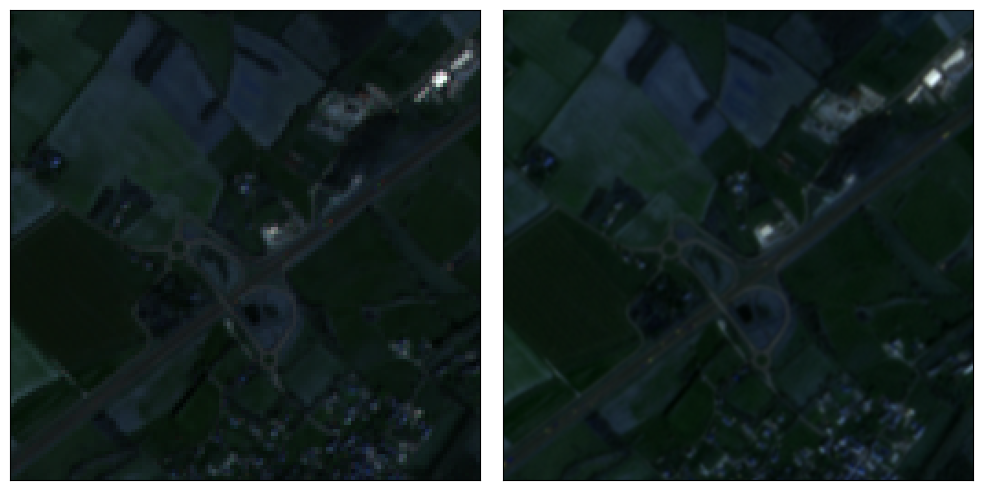

In [26]:
plot_gallery(
    [x_train[1].permute(1,2,0), y_train[1].permute(1,2,0)],
    xscale= 5,
    yscale=5
)

## SRCNN Architecture

In [27]:
class SRCNN(nn.Module):
    """
    A CNN-autoencoder used for super resolution of images, by a factor of 2.
    """
    def __init__(self,f1=9,n1=64,f2=1,n2=32,f3=5,c=3):
        super().__init__()

        # paddings are chosen so that outputs remain the same size
        p1 = (f1 - 1)//2 
        p2 = (f2 - 1)//2
        p3 = (f3 - 1)//2

        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)
        self.conv1 = nn.Conv2d(c, n1, f1,padding=p1)
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(n1,n2,f2,padding=p2)
        self.conv3 = nn.Conv2d(n2,c,f3,padding=p3)

        nn.init.normal_(self.conv1.weight, mean=0, std=0.001)
        nn.init.constant_(self.conv1.bias, 0)
        nn.init.normal_(self.conv2.weight, mean=0, std=0.001)
        nn.init.constant_(self.conv2.bias, 0)
        nn.init.normal_(self.conv3.weight, mean=0, std=0.001)
        nn.init.constant_(self.conv3.bias, 0)

        # initialise parameters 
        # self.conv1.weight, self.conv1.bias = nn.Parameter(0.001*torch.randn(n1,c,f1,f1)), nn.Parameter(torch.zeros(n1))
        # self.conv2.weight, self.conv2.bias = nn.Parameter(0.001*torch.randn(n2,n1,f2,f2)), nn.Parameter(torch.zeros(n2))
        # self.conv3.weight, self.conv3.bias = nn.Parameter(0.001*torch.randn(c,n2,f3,f3)), nn.Parameter(torch.zeros(c))

        # self.upscale = nn.Sequential(nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False),
        #                              nn.Conv2d(c, n1, f1,padding=p1),
        #                              nn.ReLU(),
        #                              nn.Conv2d(n1,n2,f2,padding=p2),
        #                              nn.ReLU(),
        #                              nn.Conv2d(n2,c,f3,padding=p3),
        #                              )
    def forward(self,x):
        x = self.upsample(x)
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.conv3(x)
        return x
    
def output_size(N,F,P=0,D=1,S=1):
    return (N + 2*P - D*(F-1)-1)//S + 1

In [28]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(models.vgg16(weights="VGG16_Weights.DEFAULT").features[:4].eval())
        blocks.append(models.vgg16(weights="VGG16_Weights.DEFAULT").features[4:9].eval())
        blocks.append(models.vgg16(weights="VGG16_Weights.DEFAULT").features[9:16].eval())
        blocks.append(models.vgg16(weights="VGG16_Weights.DEFAULT").features[16:23].eval())
        
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False # disable gradient computation
        
        self.blocks = nn.ModuleList(blocks)
        
        # self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        # self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def forward(self, x, y,  device, feature_layers = [0,1,2,3], style_layers = []):
        loss = 0 
        for i, block in enumerate(self.blocks):
            block = block.to(device)
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += nn.functional.mse_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += nn.functional.mse_loss(gram_x, gram_y)
        return loss       

In [18]:
vgg = VGGPerceptualLoss()
vgg.blocks

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (1): Sequential(
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
  )
  (2): Sequential(
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
  (3): Sequentia

## Training

In [29]:
import torch.optim as optim
# from torch.utils.data import DataLoader
import tqdm
from torch.utils.data import DataLoader, Dataset
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class DatasetWrapper(Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.y[idx]

In [30]:
should_pin_memory = {"cuda": True, "cpu": False}

def train(model, x: torch.tensor, y: torch.tensor, lossfunc = nn.MSELoss(), 
          batch_size = 8, nepochs = 10, lr = 10e-4):
    
    losses = []
    epoch_losses = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = optim.Adam(
        [
            {"params": model.conv1.parameters(), "lr": 10e-4},
            {"params": model.conv2.parameters(), "lr": 10e-4},
            {"params": model.conv3.parameters(), "lr": 10e-5}
        ],
        lr=lr)

    # training loop
    dataloader = DataLoader(DatasetWrapper(x,y),
                              shuffle=True,  # Always set to true for training
                              batch_size=batch_size,  # Always try to set as powers of 2
                              drop_last=True  # Ensures batch size is always the one given (Drops last if its is smaller)
                                 # Faster push to GPU 
                              )
    
    vgg = VGGPerceptualLoss().eval()

    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        t0 = time()
        
        epoch_loss = 0
        n_batches = 0 
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            n_batches += 1
            optimizer.zero_grad()

            # Move mini-batch data to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # forward pass through the CNN
            out = model.forward(x_batch)
            
            # compute perceptuual loss
            loss = vgg.forward(out, y_batch, device = device)
            epoch_loss += loss.item()
            losses.append(loss.item())

            # gradient descent 
            loss.backward()
            optimizer.step()

        
        epoch_losses.append(epoch_loss)  
        epoch_loss /= n_batches
        loop.set_postfix(loss="%5.5f" % (epoch_loss)) 

    return losses, epoch_losses

def test(model, x: torch.tensor, y: torch.tensor, batch_size = 64, lossfunc = nn.MSELoss()):
    with torch.no_grad():# disable automatic gradient computation for efficiency
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        loss = 0
        n_batches = 0
        
        dataloader = DataLoader(DatasetWrapper(x,y),
                                shuffle=False,  # Always set to true for training
                                batch_size=batch_size,  # Always try to set as powers of 2
                                drop_last=True  # Ensures batch size is always the one given (Drops last if its is smaller) 
                              )
        
        for x_batch, y_batch in dataloader:
            n_batches += 1
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model.forward(x_batch)
            loss += lossfunc(out, y_batch)
    
        return (1/n_batches)*loss
    

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
torch.manual_seed(1)
model = SRCNN(f2=3)
torch.cuda.empty_cache()
losses, epoch_losses = train(model, x_train, y_train, nepochs=100, batch_size = 128, lr = 10e-5)

  0%|                                                                                 | 0/100 [00:00<?, ?it/s]


ZeroDivisionError: division by zero

In [9]:
torch.save(model,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/model_vggloss.pt")

In [10]:
model = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/model.pt")

In [11]:
print(f"Train set accuracy: {test(model, x_train[:128], y_train[:128]):.4f}")
print(f"Test set accuracy: {test(model, x_test[:128], y_test[:128]):.4f}")

Train set accuracy: 0.0019
Test set accuracy: 0.0019


## Plotting predictions 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


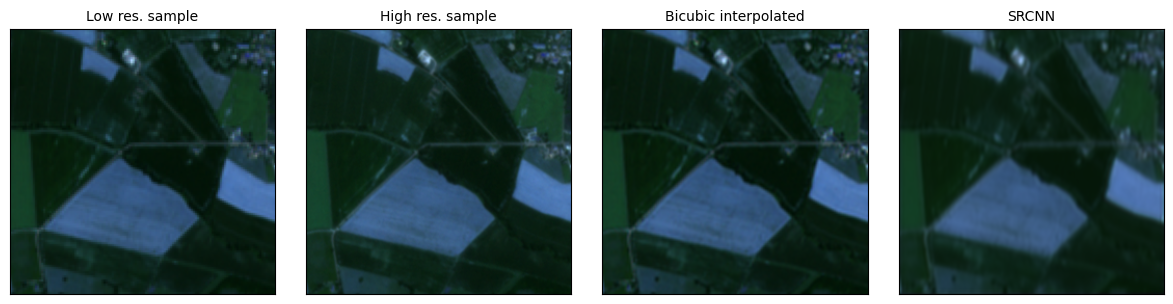

In [17]:
i = 100

out = model.forward(x_test[:128].to(torch.device("cuda")))
o = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(x_test[:128])

plot_gallery(
    [x_test[i].permute(1,2,0),
    y_test[i].permute(1,2,0),
    o[i].permute(1,2,0), 
    out[i].cpu().detach().permute(1,2,0)],
    xscale=3,
    yscale=3,
    titles =
    ["Low res. sample", 
     "High res. sample",
     "Bicubic interpolated",
     "SRCNN"],
     output="C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/figures/vgg_loss_sample.png"
)